# Bayesian Optimization & Supervised Machine Learning

## Overview
1. Load sonar all data
2. Prepared Data
3. Split data into training and testing datasets
4. Encode data for Xgboost (matrix)
5. Train ML models
6. Evaluate ML performance
7. Confusion Matrix
8. Save Model
9. Load Model
10. Predict on new data

In [1]:
# Import Libraries.

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold


In [2]:
# Check GPU
from catboost.utils import get_gpu_device_count
print('\n%i GPU devices available' % get_gpu_device_count())



1 GPU devices available


In [3]:

# Metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from time import time

# # Bayesian Optimization - skopt
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
from skopt.space import Real, Categorical, Integer

# Catboost
from catboost import CatBoostClassifier, Pool
import ipywidgets # Nødvendig for plot



In [4]:
# Udeståender - Backlog

# Model selection
# Reference: https://www.kaggle.com/shivampanwar/catboost-and-hyperparameter-tuning-using-bayes


# Udeståender:
# Håndtering af categorial features. [ok]

# Prioritering:
# SHAP på multiclass. -> OK (Shapvalues & Explainer). 
# SHAP values fylder 5 GB. Tilrette, så vi får et mindre antal. [Mikkel tjekker mulighederne med Explainer fra SHAP og holder dette op i mod Catboost]

# Learning Curve [Pt. under udarbejdelse - Mikkel]. Muligvis et python pakke issue (ipywidget..)
# RoC Curve for multiclassification catboost. [WiP]. 
# Save Model [med alle attributter, så true = true] -> Mikkel. [ok, catboost har en begrænsning, der gør at den ikke kan vise _best_model efter load. ]

# Løb over 01_feature_importance og simplificer SHAP koden + dokumenter kode yderligere. 

# Løsningen:
# Lav funktion, der gør det let at tage et område og lave XAI på. På samme måde, som når vi skal lave et nyt predict Shapefile kort.


# Ændring af Confusion Matrix (skjul antallet af labels) [09.10.2020 - Ok]

# Rette kode på VM-produktionsserver:
# Ændre fra random numpy til sklearn med random_state = 42. Re-producerbart resultat.


# Evt.
# Visualisering af learning curve - LIVE imens modellen trænes. [Undersøgt, og pt. ikke afklaret? catboost henviser selv til et eller andet med widgets og live charts]
# log-uniform virker ikke med search space.
# Visualisering af decision tree - nederste niveau med klasse
# Correlationsmatrix - rette størrelse og tekst.


## Deployment ##
# Save Model [med alle attributter, så true = true] -> Mikkel. [ Alt virker med almindelig save og CBM format, _best.model kan findes på anden vis]

# load model -> Mikkel. Så vi kan loade med best_parameters etc.

# Predict "nye data"

# Bayesian Optimization koden. Tilrette, så vi får løftet den over i VM-produktionsboksen.

In [5]:
import sys
import catboost as cb
print('CatBoost version=%s' % cb.__version__)


print('ipywidgets version=%s' % ipywidgets.__version__)


CatBoost version=0.24
ipywidgets version=7.5.1


### Load simple binary classification dataset.

In [5]:
##########################
# Load dataset fra min github
from pandas import read_csv
url = 'https://raw.githubusercontent.com/kurtholst/databricks_proj/master/sonar.all-data.csv'

dataset = read_csv(url, header=None)
print(dataset.head(5))

# Class distribution
print("Class distribution:")
print(dataset[60].value_counts())

       0       1       2       3       4       5       6       7       8   \
0  0.0200  0.0371  0.0428  0.0207  0.0954  0.0986  0.1539  0.1601  0.3109   
1  0.0453  0.0523  0.0843  0.0689  0.1183  0.2583  0.2156  0.3481  0.3337   
2  0.0262  0.0582  0.1099  0.1083  0.0974  0.2280  0.2431  0.3771  0.5598   
3  0.0100  0.0171  0.0623  0.0205  0.0205  0.0368  0.1098  0.1276  0.0598   
4  0.0762  0.0666  0.0481  0.0394  0.0590  0.0649  0.1209  0.2467  0.3564   

       9   ...      51      52      53      54      55      56      57  \
0  0.2111  ...  0.0027  0.0065  0.0159  0.0072  0.0167  0.0180  0.0084   
1  0.2872  ...  0.0084  0.0089  0.0048  0.0094  0.0191  0.0140  0.0049   
2  0.6194  ...  0.0232  0.0166  0.0095  0.0180  0.0244  0.0316  0.0164   
3  0.1264  ...  0.0121  0.0036  0.0150  0.0085  0.0073  0.0050  0.0044   
4  0.4459  ...  0.0031  0.0054  0.0105  0.0110  0.0015  0.0072  0.0048   

       58      59  60  
0  0.0090  0.0032   R  
1  0.0052  0.0044   R  
2  0.0095  0.0078   

In [6]:
#  Naturtype features.

In [21]:
import pandas as pd
import os
df = pd.read_pickle(os.path.join("C:\\Users\\b051827\Documents\\Projekter\\Habitat og naturgenkendelse\\JUMP-Billedgenkendelse\\00_data\\03_feats_embed.pkl"))

print("Dataframe shape")
print(df.shape)

print("Features")
print(df.columns)

print("Naturtype distribution")
print(df['NATURTYPE'].value_counts())

Dataframe shape
(102381, 194)
Features
Index(['geometry', 'NATURTYPE', 'humidity_01', 'humidity_02', 'humidity_03', 'humidity_04',
       'pressure_01', 'pressure_02', 'pressure_03', 'pressure_04',
       ...
       'SOP_RGB_00', 'SOP_RGB_01', 'SOP_RGB_02', 'SOP_RGB_03', 'SOP_RGB_04', 'SOP_RGB_05',
       'SOP_RGB_06', 'SOP_RGB_07', 'SOP_RGB_08', 'SOP_RGB_09'],
      dtype='object', length=194)
Naturtype distribution
Bøg på kalk                         3000
Skovklit                            3000
Stilkege-krat                       2999
Ege-blandskov                       2999
Bøg på mor med kristtorn            2998
Skovbevokset tørvemose              2997
Nedbrudt højmose                    2997
Kalkoverdrev                        2996
Bøg på muld                         2995
Hængesæk                            2995
Højmose                             2995
Elle- og askeskov                   2994
Bøg på mor                          2994
Surt overdrev                       2992
Stran

In [22]:
# EDA Naturtype
# convert NATURTYPE to NATURTYPE_full - label incl. nr. for biologer
df_colors = pd.read_excel(os.path.abspath("C:\\Users\\b051827\Documents\\Projekter\\Habitat og naturgenkendelse\\JUMP-Billedgenkendelse\\03_output_generation\\naturtype_colours.xlsm"))
nt2ntfull = {row['alt_name']: row['name'] for idx, row in df_colors.iterrows()}
df['NATURTYPE_full'] = df.NATURTYPE.apply(nt2ntfull.get)
df.head(5)



,geometry,NATURTYPE,humidity_01,humidity_02,humidity_03,humidity_04,pressure_01,pressure_02,pressure_03,pressure_04,snow_01,snow_02,snow_03,snow_04,temperature_mean_01,temperature_mean_02,temperature_mean_03,temperature_mean_04,temperature_min_01,temperature_min_02,temperature_min_03,temperature_min_04,temperature_max_01,temperature_max_02,temperature_max_03,temperature_max_04,wind_mean_01,wind_mean_02,wind_mean_03,wind_mean_04,wind_max_01,wind_max_02,wind_max_03,wind_max_04,winddir_01,winddir_02,winddir_03,winddir_04,precip_01,precip_02,precip_03,precip_04,x,y,earth,dist_coast,dist_lake,dist_river,summer_B02,summer_B03,summer_B04,summer_B05,summer_B06,summer_B07,summer_B11,summer_B12,summer_B8A,winter_B02,winter_B03,winter_B04,winter_B05,winter_B06,winter_B07,winter_B11,winter_B12,winter_B8A,spring_B02,spring_B03,spring_B04,spring_B05,spring_B06,spring_B07,spring_B11,spring_B12,spring_B8A,autumn_B02,autumn_B03,autumn_B04,autumn_B05,autumn_B06,autumn_B07,autumn_B11,autumn_B12,autumn_B8A,DSM_DTM_0,DSM_DTM_1,DSM_DTM_2,DSM_DTM_3,DSM_DTM_4,DSM_DTM_5,DSM_DTM_6,DSM_DTM_7,SOP_NDVI_median,SOP_NDVI_std,FOP_NDVI_median,FOP_NDVI_std,d_NDVI_median,d_NDVI_std,DSM_median,DSM_std,DTM_median,DTM_std,DSM_DTM_median,DSM_DTM_std,lidar_number_of_returns_median,lidar_number_of_returns_std,lidar_returns_2,lidar_returns_3,lidar_returns_4,lidar_returns_5,summer_ARI1,summer_ARI2,summer_CRE,summer_EVI,summer_PSRI,summer_CMR,summer_FMR,summer_IOR,summer_BAI,summer_MNDWI,summer_NDBI,winter_ARI1,winter_ARI2,winter_CRE,winter_EVI,winter_PSRI,winter_CMR,winter_FMR,winter_IOR,winter_BAI,winter_MNDWI,winter_NDBI,spring_ARI1,spring_ARI2,spring_CRE,spring_EVI,spring_PSRI,spring_CMR,spring_FMR,spring_IOR,spring_BAI,spring_MNDWI,spring_NDBI,autumn_ARI1,autumn_ARI2,autumn_CRE,autumn_EVI,autumn_PSRI,autumn_CMR,autumn_FMR,autumn_IOR,autumn_BAI,autumn_MNDWI,autumn_NDBI,d_B02,d_B03,d_B04,d_B05,d_B06,d_B07,d_B11,d_B12,d_B8A,d_ARI1,d_ARI2,d_CRE,d_EVI,d_PSRI,d_CMR,d_FMR,d_IOR,d_BAI,d_MNDWI,d_NDBI,FOP_RGB_00,FOP_RGB_01,FOP_RGB_02,FOP_RGB_03,FOP_RGB_04,FOP_RGB_05,FOP_RGB_06,FOP_RGB_07,FOP_RGB_08,FOP_RGB_09,SOP_RGB_00,SOP_RGB_01,SOP_RGB_02,SOP_RGB_03,SOP_RGB_04,SOP_RGB_05,SOP_RGB_06,SOP_RGB_07,SOP_RGB_08,SOP_RGB_09,NATURTYPE_full
418,POINT (449269.000 6187414.000),Tidvis våd eng,89.273,80.770,81.688,89.80,1013.852,1014.513,1014.553,1013.891,0.0,0.0,0.0,0.0,2.707,11.423,15.475,7.421,-0.4,6.2,10.6,3.8,5.7,15.8,19.7,9.8,5.251,4.539,4.174,4.951,14.8,14.0,13.95,15.8,196.014,229.406,224.108,204.675,0.132,0.261,0.49,0.785,4.0,62.0,HV,512.0,2048.0,4096.0,275,566,423,1090,2882,3437,2225,1088,3768,743,765,839,1329,1946,2305,2321,1361,2589,363,662,572,1234,2788,3288,2630,1418,3785,635,855,662,1329,2992,3604,2633,1361,4015,622.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.016,0.026,0.012,0.019,0.003,0.016,1.494,0.133,1.492,0.133,0.0,0.007,1.0,0.0,0.0,0.0,0.0,0.0,0.003,9.226,4107120,1.970,0.051,2.045,0.590,1.538,6.956e-08,-0.681,-0.257,0.002,4.747,3440781,2.133,0.049,1.705,0.896,1.129,1.350e-07,-0.469,-0.055,0.002,7.631,4670690,1.787,0.075,1.855,0.695,1.576,6.825e-08,-0.643,-0.180,0.002,6.927,5335935,2.599,0.009,1.935,0.656,1.043,6.039e-08,-0.598,-0.208,-468,-199,-416,-239,936,1132,-96,-273,1179,6.246e-04,4.478,666339,-0.162,0.002,0.340,-0.306,0.409,-6.546e-08,-0.212,-0.203,67440.711,1355.060,-1001.160,-125.798,-1443.589,-5489.347,-6314.114,-1778.079,-2907.076,4732.040,-63019.621,-7000.879,1396.964,-13009.307,-623.110,4252.360,-1862.316,7182.160,2365.168,-1395.517,6410 - Tidvis våd eng
419,POINT (449248.000 6187456.000),Grå/grøn klit,89.273,80.770,81.688,89.80,1013.852,1014.513,1014.553,1013.891,0.0,0.0,0.0,0.0,2.707,11.423,15.475,7.421,-0.4,6.2,10.6,3.8,5.7,15.8,19.7,9.8,5.251,4.539,4.174,4.951,14.8,14.0,13.95,15.8,196.014,229.406,224.108,204.675,0.132,0.261,0.49,0.785,4.0,62.0,HV,512.0,2048.0,4096.0,358,662,519,1191,2848,3374,2266,1196,3737,682,737,792,1350,2051,2263,2176,1261,2641,481,793,738,1426,2637,3126,2637,1477,3448,318,614,579,1198,2230,2634,2278,1304,2998,615.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,

In [8]:
# split into features & class

# Fjern target og geometry fra features
# Catboost skal tage imod Earth. To-DO.

# Fjern urtebrømme
df = df[df.NATURTYPE_full!="6430 - Urtebræmme"]
y = df.NATURTYPE_full
X = df.drop(columns=['NATURTYPE', 'NATURTYPE_full', 'geometry']) #'color', 'train', 

print(X.shape)


#y = y[y!="6430 - Urtebræmme"]
# Target nu med kode og tekst
print(y)

(102378, 192)
418      6410 - Tidvis våd eng
419       2130 - Grå/grøn klit
420      6410 - Tidvis våd eng
421           1330 - Strandeng
422       2130 - Grå/grøn klit
                 ...          
97259     9170 - Vinteregeskov
97382          2180 - Skovklit
97647          2180 - Skovklit
97649          2180 - Skovklit
98626          2180 - Skovklit
Name: NATURTYPE_full, Length: 102378, dtype: object


In [9]:
# Split-out validation dataset i data og target klasse.

# Sonar data
# array = dataset.values
# data = array[:,0:60].astype(float)
# X = data
# targets = array[:,60]
# y = targets
# Naturtype data:
#X = df[]
#y = targets

#####################################
# Split i training og test dataset. #
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                    train_size = 0.8,
                                                    test_size = 0.2,
                                                    random_state = 42)
print("Labels for training and testing data")
print(train_y)
print(test_y)

Labels for training and testing data
56641                      2110 - Forklit
55498                      2110 - Forklit
86879     9999 - 91E0 - Elle- og askeskov
59358                     4010 - Våd hede
46946              7220.2 - Skovkildevæld
                       ...               
27994     9120 - Bøg på mor med kristtorn
101464    9120 - Bøg på mor med kristtorn
36087                2130 - Grå/grøn klit
25233                     2140 - Klithede
8057                      4010 - Våd hede
Name: NATURTYPE_full, Length: 81902, dtype: object
87767                       9110 - Bøg på mor
49722                    6230 - Surt overdrev
45237                     6210 - Kalkoverdrev
10735                   6410 - Tidvis våd eng
90070    9998 - 91D0 - Skovbevokset tørvemose
                         ...                 
93555                     9190 - Stilkegekrat
11649                        1330 - Strandeng
27423                      9130 - Bøg på muld
17446                         7140 -

In [10]:
import pandas as pd
from IPython.display import display

pd.options.display.max_columns = None
X.head()

,humidity_01,humidity_02,humidity_03,humidity_04,pressure_01,pressure_02,pressure_03,pressure_04,snow_01,snow_02,snow_03,snow_04,temperature_mean_01,temperature_mean_02,temperature_mean_03,temperature_mean_04,temperature_min_01,temperature_min_02,temperature_min_03,temperature_min_04,temperature_max_01,temperature_max_02,temperature_max_03,temperature_max_04,wind_mean_01,wind_mean_02,wind_mean_03,wind_mean_04,wind_max_01,wind_max_02,wind_max_03,wind_max_04,winddir_01,winddir_02,winddir_03,winddir_04,precip_01,precip_02,precip_03,precip_04,x,y,earth,dist_coast,dist_lake,dist_river,summer_B02,summer_B03,summer_B04,summer_B05,summer_B06,summer_B07,summer_B11,summer_B12,summer_B8A,winter_B02,winter_B03,winter_B04,winter_B05,winter_B06,winter_B07,winter_B11,winter_B12,winter_B8A,spring_B02,spring_B03,spring_B04,spring_B05,spring_B06,spring_B07,spring_B11,spring_B12,spring_B8A,autumn_B02,autumn_B03,autumn_B04,autumn_B05,autumn_B06,autumn_B07,autumn_B11,autumn_B12,autumn_B8A,DSM_DTM_0,DSM_DTM_1,DSM_DTM_2,DSM_DTM_3,DSM_DTM_4,DSM_DTM_5,DSM_DTM_6,DSM_DTM_7,SOP_NDVI_median,SOP_NDVI_std,FOP_NDVI_median,FOP_NDVI_std,d_NDVI_median,d_NDVI_std,DSM_median,DSM_std,DTM_median,DTM_std,DSM_DTM_median,DSM_DTM_std,lidar_number_of_returns_median,lidar_number_of_returns_std,lidar_returns_2,lidar_returns_3,lidar_returns_4,lidar_returns_5,summer_ARI1,summer_ARI2,summer_CRE,summer_EVI,summer_PSRI,summer_CMR,summer_FMR,summer_IOR,summer_BAI,summer_MNDWI,summer_NDBI,winter_ARI1,winter_ARI2,winter_CRE,winter_EVI,winter_PSRI,winter_CMR,winter_FMR,winter_IOR,winter_BAI,winter_MNDWI,winter_NDBI,spring_ARI1,spring_ARI2,spring_CRE,spring_EVI,spring_PSRI,spring_CMR,spring_FMR,spring_IOR,spring_BAI,spring_MNDWI,spring_NDBI,autumn_ARI1,autumn_ARI2,autumn_CRE,autumn_EVI,autumn_PSRI,autumn_CMR,autumn_FMR,autumn_IOR,autumn_BAI,autumn_MNDWI,autumn_NDBI,d_B02,d_B03,d_B04,d_B05,d_B06,d_B07,d_B11,d_B12,d_B8A,d_ARI1,d_ARI2,d_CRE,d_EVI,d_PSRI,d_CMR,d_FMR,d_IOR,d_BAI,d_MNDWI,d_NDBI,FOP_RGB_00,FOP_RGB_01,FOP_RGB_02,FOP_RGB_03,FOP_RGB_04,FOP_RGB_05,FOP_RGB_06,FOP_RGB_07,FOP_RGB_08,FOP_RGB_09,SOP_RGB_00,SOP_RGB_01,SOP_RGB_02,SOP_RGB_03,SOP_RGB_04,SOP_RGB_05,SOP_RGB_06,SOP_RGB_07,SOP_RGB_08,SOP_RGB_09
418,89.273293,80.770229,81.687866,89.799694,1013.852234,1014.512665,1014.552673,1013.890686,0.0,0.0,0.0,0.0,2.707260,11.423378,15.475015,7.420623,-0.4,6.2,10.6,3.8,5.7,15.8,19.700001,9.8,5.251411,4.539159,4.174161,4.951305,14.8,14.0,13.95,15.8,196.013985,229.405937,224.108330,204.675323,0.131505,0.260873,0.490099,0.785188,4.0,62.0,HV,512.0,2048.0,4096.0,275,566,423,1090,2882,3437,2225,1088,3768,743,765,839,1329,1946,2305,2321,1361,2589,363,662,572,1234,2788,3288,2630,1418,3785,635,855,662,1329,2992,3604,2633,1361,4015,622.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.016077,0.025810,0.012158,0.018970,0.003268,0.015915,1.494141,0.133125,1.492188,0.133233,0.0,0.007464,1.0,0.0,0.0,0.0,0.0,0.0,0.002684,9.225649,4107120,1.970197,0.051353,2.045037,0.590499,1.538182,6.955933e-08,-0.680514,-0.257467,0.002060,4.747459,3440781,2.132586,0.049332,1.705364,0.896485,1.129206,1.350190e-07,-0.468987,-0.054582,0.002321,7.631273,4670690,1.786787,0.074964,1.854725,0.694848,1.575758,6.824615e-08,-0.642723,-0.180047,0.001922,6.927018,5335935,2.598822,0.009024,1.934607,0.655791,1.042520,6.039430e-08,-0.598179,-0.207882,-468,-199,-416,-239,936,1132,-96,-273,1179,0.000625,4.478191,666339,-0.162389,0.002021,0.339673,-0.305986,0.408976,-6.545970e-08,-0.211526,-0.202885,67440.710938,1355.059570,-1001.159668,-125.797852,-1443.589355,-5489.347168,-6314.113770,-1778.078857,-2907.076172,4732.040039,-63019.621094,-7000.878906,1396.963623,-13009.306641,-623.110291,4252.359863,-1862.316406,7182.160156,2365.167725,-1395.516602
419,89.273293,80.770229,81.687866,89.799694,1013.852234,1014.512665,1014.552673,1013.890686,0.0,0.0,0.0,0.0,2.707260,11.423378,15.475015,7.420623,-0.4,6.2,10.6,3.8,5.7,15.8,19.700001,9.8,5.251411,4.539159,4.174161,4.951305,14.8,14.0,13.95,15.8,196.013985,229.405937,224.108330,204.675323,0.131505,0.260873,0.

In [11]:
# Correlations between attributes
# Pairwise Pearson correlations

from pandas import set_option
set_option('display.width', 100)
set_option('precision', 3)

correlations = X.corr(method='pearson')
correlations = correlations.dropna(how='all', axis=0) # Fjern features med NA
correlations = correlations.dropna(how='all', axis=1) 

In [12]:
# Correlation
correlations[0:10]


,humidity_01,humidity_02,humidity_03,humidity_04,pressure_01,pressure_02,pressure_03,pressure_04,temperature_mean_01,temperature_mean_02,temperature_mean_03,temperature_mean_04,temperature_min_01,temperature_min_02,temperature_min_03,temperature_min_04,temperature_max_01,temperature_max_02,temperature_max_03,temperature_max_04,wind_mean_01,wind_mean_02,wind_mean_03,wind_mean_04,wind_max_01,wind_max_02,wind_max_03,wind_max_04,winddir_01,winddir_02,winddir_03,winddir_04,precip_01,precip_02,precip_03,precip_04,x,y,dist_coast,dist_lake,dist_river,summer_B02,summer_B03,summer_B04,summer_B05,summer_B06,summer_B07,summer_B11,summer_B12,summer_B8A,winter_B02,winter_B03,winter_B04,winter_B05,winter_B06,winter_B07,winter_B11,winter_B12,winter_B8A,spring_B02,spring_B03,spring_B04,spring_B05,spring_B06,spring_B07,spring_B11,spring_B12,spring_B8A,autumn_B02,autumn_B03,autumn_B04,autumn_B05,autumn_B06,autumn_B07,autumn_B11,autumn_B12,autumn_B8A,DSM_DTM_0,DSM_DTM_1,DSM_DTM_2,DSM_DTM_3,DSM_DTM_4,DSM_DTM_5,DSM_DTM_6,DSM_DTM_7,SOP_NDVI_median,SOP_NDVI_std,FOP_NDVI_median,FOP_NDVI_std,d_NDVI_median,d_NDVI_std,DSM_median,DSM_std,DTM_median,DTM_std,DSM_DTM_median,DSM_DTM_std,lidar_number_of_returns_median,lidar_number_of_returns_std,lidar_returns_2,lidar_returns_3,lidar_returns_4,lidar_returns_5,summer_ARI1,summer_ARI2,summer_CRE,summer_EVI,summer_PSRI,summer_CMR,summer_FMR,summer_IOR,summer_BAI,summer_MNDWI,summer_NDBI,winter_ARI1,winter_ARI2,winter_CRE,winter_EVI,winter_PSRI,winter_CMR,winter_FMR,winter_IOR,winter_BAI,winter_MNDWI,winter_NDBI,spring_ARI1,spring_ARI2,spring_CRE,spring_EVI,spring_PSRI,spring_CMR,spring_FMR,spring_IOR,spring_BAI,spring_MNDWI,spring_NDBI,autumn_ARI1,autumn_ARI2,autumn_CRE,autumn_EVI,autumn_PSRI,autumn_CMR,autumn_FMR,autumn_IOR,autumn_BAI,autumn_MNDWI,autumn_NDBI,d_B02,d_B03,d_B04,d_B05,d_B06,d_B07,d_B11,d_B12,d_B8A,d_ARI1,d_ARI2,d_CRE,d_EVI,d_PSRI,d_CMR,d_FMR,d_IOR,d_BAI,d_MNDWI,d_NDBI,FOP_RGB_00,FOP_RGB_01,FOP_RGB_02,FOP_RGB_03,FOP_RGB_04,FOP_RGB_05,FOP_RGB_06,FOP_RGB_07,FOP_RGB_08,FOP_RGB_09,SOP_RGB_00,SOP_RGB_01,SOP_RGB_02,SOP_RGB_03,SOP_RGB_04,SOP_RGB_05,SOP_RGB_06,SOP_RGB_07,SOP_RGB_08,SOP_RGB_09
humidity_01,1.000,0.663,0.613,0.380,-0.422,-0.158,-0.165,-0.346,0.363,-0.369,-0.374,0.223,0.033,-0.173,-0.271,-0.045,0.550,-0.407,-0.423,0.373,0.328,0.442,0.359,0.203,0.357,0.436,0.428,0.321,-0.475,0.629,0.120,-0.297,0.506,0.536,0.643,0.574,-0.350,0.070,0.030,-0.231,-0.188,0.038,0.037,0.042,0.035,-0.065,-0.076,0.059,0.063,-0.071,0.015,3.302e-02,0.050,0.045,0.037,0.033,0.036,0.036,0.025,0.080,0.068,0.078,0.072,-0.050,-0.059,0.115,0.111,-0.054,0.060,0.063,0.065,0.073,0.023,0.010,0.115,0.100,0.013,0.149,0.053,0.023,-0.012,-2.543e-02,-0.084,-0.154,-0.030,-0.013,-0.142,-0.046,-0.144,0.016,-0.114,-0.126,-0.175,-0.102,-0.046,-0.154,-0.172,-0.022,0.018,-0.126,-0.154,-0.143,-0.088,-8.822e-03,-0.028,0.005,-6.851e-03,3.030e-03,-0.081,0.097,0.007,-0.002,0.037,0.108,-0.003,-0.018,0.035,-0.002,0.017,-2.572e-02,0.028,0.038,-0.002,0.038,3.060e-02,0.004,-0.022,0.041,-1.021e-02,2.655e-02,-0.115,0.137,6.481e-03,-0.002,0.075,0.139,-0.018,9.752e-03,0.052,0.002,0.023,-0.087,0.151,0.024,-0.002,0.044,0.171,0.025,0.005,-0.007,-0.014,-0.081,-0.086,0.022,0.039,-0.078,-4.082e-04,0.003,-0.034,1.069e-03,-0.011,-0.056,0.060,-0.034,-1.595e-03,0.003,0.073,0.067,4.664e-03,-0.124,0.017,-0.145,0.047,-0.067,-0.114,0.025,0.075,0.020,-0.037,-0.062,0.039,-0.037,-4.019e-02,0.068,0.027,-0.110,-1.198e-02
humidity_02,0.663,1.000,0.735,-0.224,-0.390,-0.335,-0.352,-0.473,0.377,-0.768,-0.242,0.458,0.214,-0.044,0.018,0.221,0.317,-0.773,-0.654,0.243,0.740,0.744,0.708,0.673,0.722,0.680,0.686,0.698,-0.316,0.260,0.144,-0.052,0.584,0.457,0.534,0.516,-0.136,0.132,-0.162,0.269,0.140,0.079,0.072,0.076,0.068,-0.081,-0.106,0.055,0.077,-0.105,0.021,4.295e-02,0.055,0.050,0.043,0.035,0.029,0.031,0.020,0.104,0.089,0.094,0.087,-0.084,-0.109,0.086,0.101,-0.110,0.102,0.099,0.112,0.112,0.019,-0.004,0.134,0.131,-0.002,0.119,0.050,0.037,0.006,4.441e-03,-0.037,-0.160,-0.026,0.018,-0.078

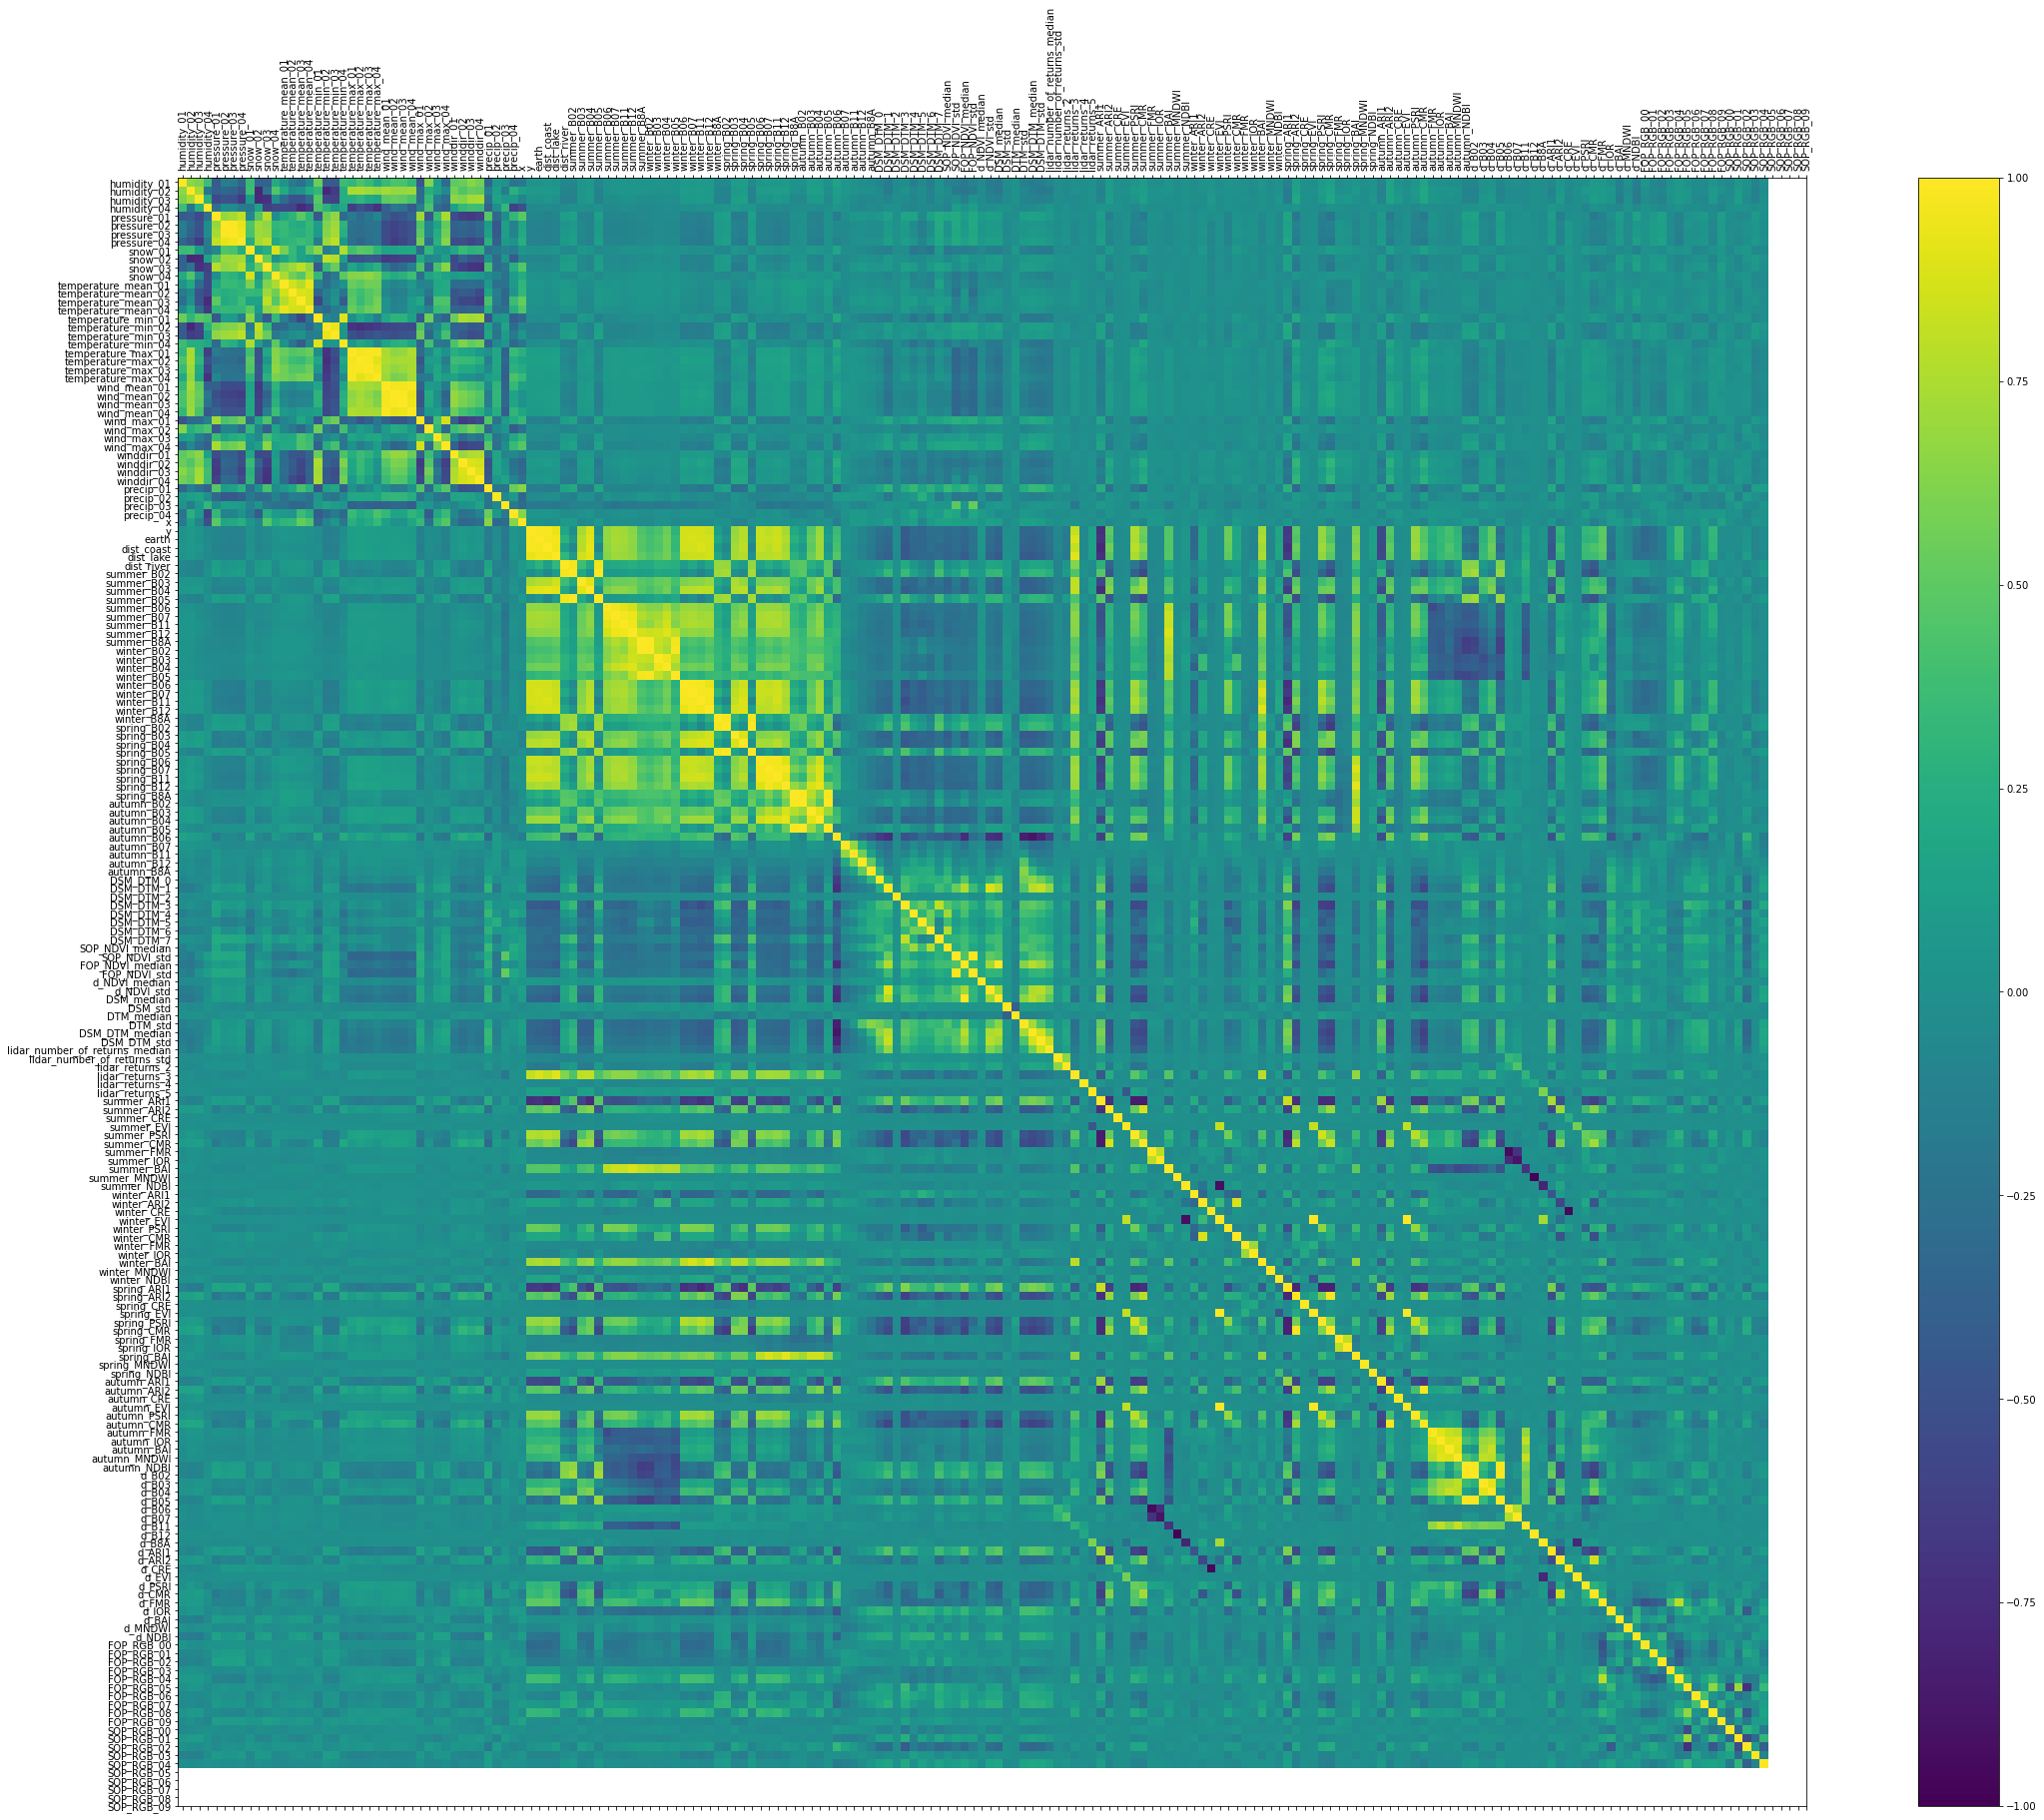

In [16]:
# Correction Matrix Plot
# TO-DO: Assistance fra Mikkel.
import matplotlib.pyplot as plt
import numpy as np
names = X.columns

fig = plt.figure(figsize=(40, 30))
ax = fig.add_subplot()
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,192,1) # 192 = Number of features
plt.xticks(rotation=90)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)

plt.show()

# Supervised Learning med Catboost

In [37]:
model_cb = cb.CatBoostClassifier(eval_metric   = 'Accuracy',
                                 random_seed   = 1337, 
                                 metric_period = 10, 
                                 loss_function = 'MultiClass',
                                 #loss_function='Logloss',
                                 iterations    = 100, #5000, # 100000
                                 task_type     = 'GPU', 
                                 devices       = '0:1', 
                                 od_type       = 'Iter', 
                                 od_wait       = 2000, 
                                 cat_features = ['earth'],
                                 train_dir = "accuracy"
                                ) # Early stopping. Når modellen ikke har forbedret sig i od_wait iterationer

In [38]:
?cb.CatBoostClassifier


In [39]:
%%time
model_cb.fit(X = train_X, y = train_y, 
             eval_set=(test_X, test_y), # Tilføj test set 
             plot = True, 
             #cat_features = ['earth'],
             verbose = True,
             use_best_model = True)
            

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.448822
0:	learn: 0.2354033	test: 0.2342743	best: 0.2342743 (0)	total: 514ms	remaining: 50.9s
10:	learn: 0.5856878	test: 0.5769193	best: 0.5769193 (10)	total: 6.14s	remaining: 49.7s
20:	learn: 0.6692999	test: 0.6507130	best: 0.6507130 (20)	total: 11.9s	remaining: 44.7s
30:	learn: 0.7118019	test: 0.6871459	best: 0.6871459 (30)	total: 17.4s	remaining: 38.7s
40:	learn: 0.7410930	test: 0.7107834	best: 0.7107834 (40)	total: 22.8s	remaining: 32.8s
50:	learn: 0.7621914	test: 0.7275835	best: 0.7275835 (50)	total: 28.1s	remaining: 27s
60:	learn: 0.7795414	test: 0.7396953	best: 0.7396953 (60)	total: 33.5s	remaining: 21.4s
70:	learn: 0.7929721	test: 0.7516605	best: 0.7516605 (70)	total: 38.8s	remaining: 15.9s
80:	learn: 0.8050963	test: 0.7601094	best: 0.7601094 (80)	total: 44.2s	remaining: 10.4s
90:	learn: 0.8159019	test: 0.7651397	best: 0.7651397 (90)	total: 49.5s	remaining: 4.9s
99:	learn: 0.8222754	test: 0.7676304	best: 0.7676304 (99)	total: 54.2s	remaining: 0us
bestTest 

In [43]:
# "Multiclass cross entropy loss.". Se mere på catboost info.
import ipywidgets 
%matplotlib inline

w = cb.MetricVisualizer("./accuracy/")
w.start


<bound method MetricVisualizer.start of MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))>

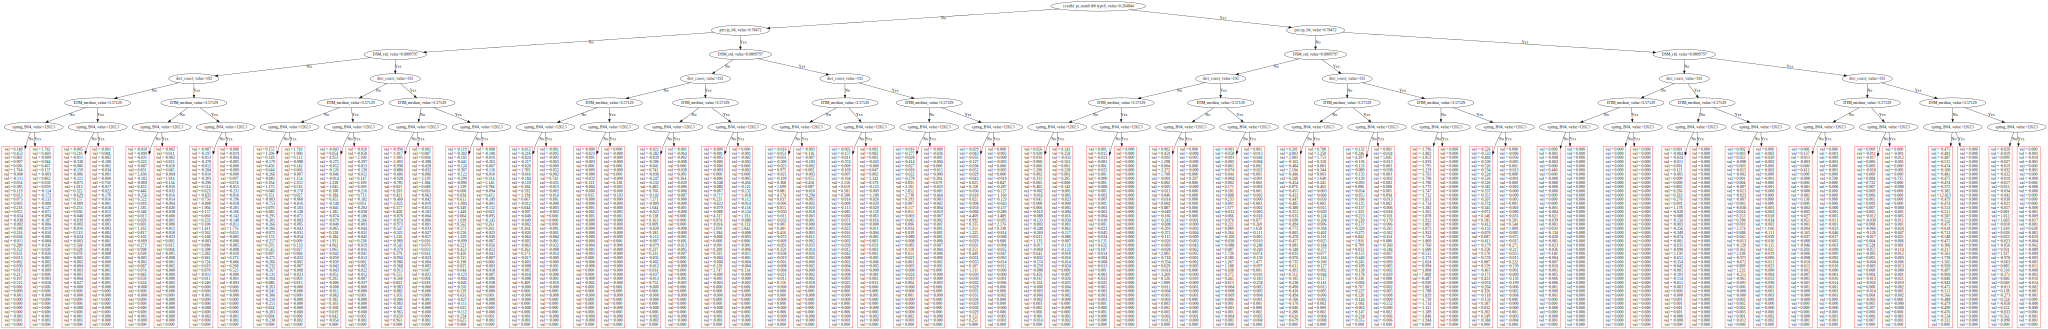

In [230]:
# Visualisering af catboost decision trees:
import graphviz
catboost_pool = Pool(data=test_X, 
                     label=test_y,
                     cat_features = ['earth'],)
model_cb.plot_tree(
    tree_idx=1,
    pool=catboost_pool)

In [14]:
# Save model as catboost model format.
# Ikke alt er gemt med model. -> [ Mikkel tager denne som hjemmeopg.]
model_cb.save_model(fname = "model_cb",
                       format = "cbm",
                       #format="python", 
                       export_parameters = None,
                       pool = None)


In [15]:
# Load Trained model
from catboost import CatBoostClassifier

model_load = CatBoostClassifier()

model_load = model_load.load_model("model_cb", format = "cbm")


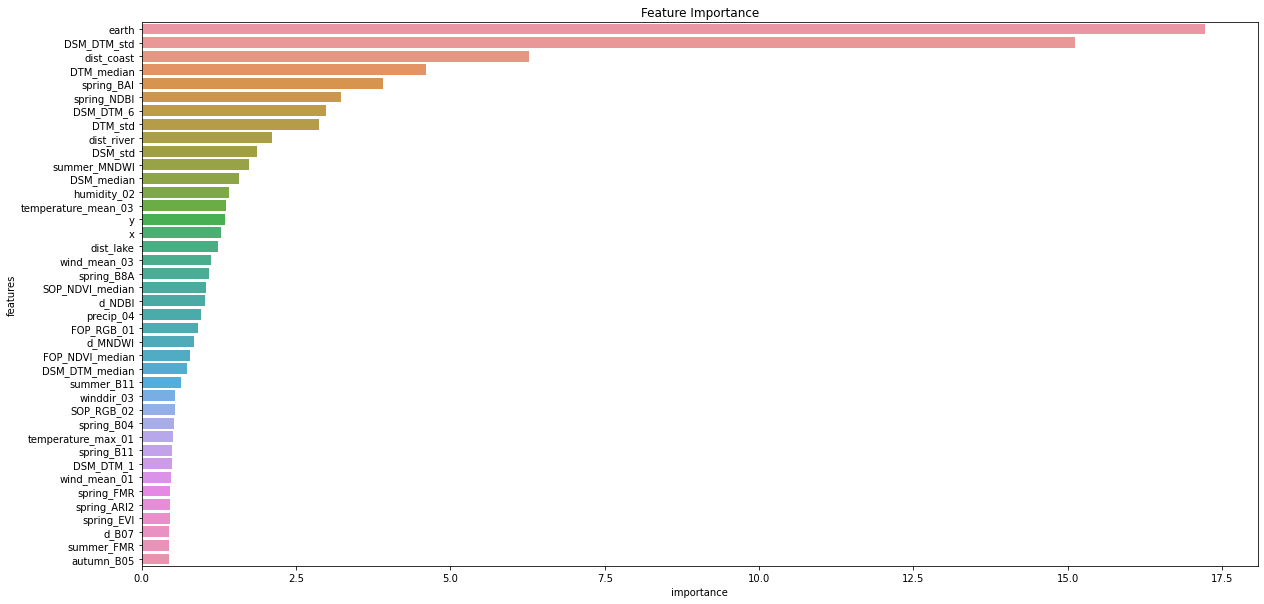

In [20]:
# Feature Importance
import seaborn as sns
import matplotlib.pyplot as plt
features_names = train_X.columns

feat_imp = pd.DataFrame()
feat_imp['importance'] = model_cb.get_feature_importance()
feat_imp['features'] = features_names
feat_imp.sort_values(by = 'importance', inplace = True, ascending = False)
max_features = 40
plt.figure(figsize=(20, 10));
sns.barplot(y = feat_imp['features'][:max_features], x = feat_imp['importance'][:max_features],)
plt.title("Feature Importance")
plt.show()

In [17]:
# Features
# Write out column order
pd.Series(train_X.columns).to_csv(os.path.abspath("C:\\Users\\b051827\Documents\\Projekter\\Habitat og naturgenkendelse\\JUMP-Billedgenkendelse\\00_data\\feature_names_cb.csv"), index=False, header=False)
feature_names_cb = list(train_X.columns)

In [18]:
# Get feature names to be used in prediction order
feature_cb_cols = pd.read_csv(os.path.abspath("C:\\Users\\b051827\Documents\\Projekter\\Habitat og naturgenkendelse\\JUMP-Billedgenkendelse\\00_data\\feature_names_cb.csv"), 
                         header=None).values.tolist()
feature_cb_cols = [col[0] for col in feature_cb_cols]


In [30]:
# Lim geometry tilbage på test-data test_X
geometry = pd.merge(test_X, df['geometry'],  left_index=True, right_index=True)
geometry.head(5)

,humidity_01,humidity_02,humidity_03,humidity_04,pressure_01,pressure_02,pressure_03,pressure_04,snow_01,snow_02,snow_03,snow_04,temperature_mean_01,temperature_mean_02,temperature_mean_03,temperature_mean_04,temperature_min_01,temperature_min_02,temperature_min_03,temperature_min_04,temperature_max_01,temperature_max_02,temperature_max_03,temperature_max_04,wind_mean_01,wind_mean_02,wind_mean_03,wind_mean_04,wind_max_01,wind_max_02,wind_max_03,wind_max_04,winddir_01,winddir_02,winddir_03,winddir_04,precip_01,precip_02,precip_03,precip_04,x,y,earth,dist_coast,dist_lake,dist_river,summer_B02,summer_B03,summer_B04,summer_B05,summer_B06,summer_B07,summer_B11,summer_B12,summer_B8A,winter_B02,winter_B03,winter_B04,winter_B05,winter_B06,winter_B07,winter_B11,winter_B12,winter_B8A,spring_B02,spring_B03,spring_B04,spring_B05,spring_B06,spring_B07,spring_B11,spring_B12,spring_B8A,autumn_B02,autumn_B03,autumn_B04,autumn_B05,autumn_B06,autumn_B07,autumn_B11,autumn_B12,autumn_B8A,DSM_DTM_0,DSM_DTM_1,DSM_DTM_2,DSM_DTM_3,DSM_DTM_4,DSM_DTM_5,DSM_DTM_6,DSM_DTM_7,SOP_NDVI_median,SOP_NDVI_std,FOP_NDVI_median,FOP_NDVI_std,d_NDVI_median,d_NDVI_std,DSM_median,DSM_std,DTM_median,DTM_std,DSM_DTM_median,DSM_DTM_std,lidar_number_of_returns_median,lidar_number_of_returns_std,lidar_returns_2,lidar_returns_3,lidar_returns_4,lidar_returns_5,summer_ARI1,summer_ARI2,summer_CRE,summer_EVI,summer_PSRI,summer_CMR,summer_FMR,summer_IOR,summer_BAI,summer_MNDWI,summer_NDBI,winter_ARI1,winter_ARI2,winter_CRE,winter_EVI,winter_PSRI,winter_CMR,winter_FMR,winter_IOR,winter_BAI,winter_MNDWI,winter_NDBI,spring_ARI1,spring_ARI2,spring_CRE,spring_EVI,spring_PSRI,spring_CMR,spring_FMR,spring_IOR,spring_BAI,spring_MNDWI,spring_NDBI,autumn_ARI1,autumn_ARI2,autumn_CRE,autumn_EVI,autumn_PSRI,autumn_CMR,autumn_FMR,autumn_IOR,autumn_BAI,autumn_MNDWI,autumn_NDBI,d_B02,d_B03,d_B04,d_B05,d_B06,d_B07,d_B11,d_B12,d_B8A,d_ARI1,d_ARI2,d_CRE,d_EVI,d_PSRI,d_CMR,d_FMR,d_IOR,d_BAI,d_MNDWI,d_NDBI,FOP_RGB_00,FOP_RGB_01,FOP_RGB_02,FOP_RGB_03,FOP_RGB_04,FOP_RGB_05,FOP_RGB_06,FOP_RGB_07,FOP_RGB_08,FOP_RGB_09,SOP_RGB_00,SOP_RGB_01,SOP_RGB_02,SOP_RGB_03,SOP_RGB_04,SOP_RGB_05,SOP_RGB_06,SOP_RGB_07,SOP_RGB_08,SOP_RGB_09,geometry
87767,88.819,79.996,82.592,89.019,1013.977,1013.686,1013.719,1012.928,0.0,0.0,0.0,0.0,1.969,10.874,15.353,6.841,-0.70,6.30,10.90,3.30,4.8,15.55,19.55,9.20,6.040,5.102,4.818,6.360,16.30,14.8,14.35,17.0,201.324,215.122,217.916,204.991,0.119,0.159,0.304,0.559,6.0,64.0,MSG,4096.0,32768.0,2048.0,73,278,150,609,3257,4594,1780,731,4942,196,328,440,779,1099,1438,1675,1004,1813,134,428,186,801,3553,4729,1877,792,5146,85,275,190,597,2616,3505,1755,725,4218,8.0,0.0,0.0,4.0,2.0,27.0,584.0,0.0,0.504,0.065,0.206,0.048,0.294,0.032,113.125,3.520,97.125,0.234,16.000,3.434,4.0,0.969,64.0,189.0,245.0,113.0,0.005,24.069,3009678,2.262,0.024,2.435,0.360,2.055,4.091e-08,-0.845,-0.470,0.004,6.230,1412327,1.150,0.222,1.668,0.924,2.245,2.873e-07,-0.584,-3.956e-02,0.004,16.953,4121946,2.358,0.015,2.370,0.365,1.388,3.771e-08,-0.820,-0.465,0.005,18.616,2518146,2.133,0.040,2.421,0.416,2.235,5.609e-08,-0.805,-0.412,-123,-50,-290,-170,2158,3156,105,-273,3129,9.067e-04,17.839,1597351,1.112,-0.198,0.767,-0.564,-0.190,-2.464e-07,-0.261,-0.431,24270.387,6357.179,-15538.096,-8329.305,-3260.949,8185.058,-137.616,-913.486,-136.798,-767.333,-33896.152,12095.449,12824.617,-10677.312,-3439.259,11374.236,1758.206,209.065,-3354.536,-1694.574,POINT (587181.000 6364737.000)
49722,88.748,77.588,81.646,90.767,1014.424,1014.827,1014.863,1014.551,0.0,0.0,0.0,0.0,2.544,11.967,15.577,7.070,-0.35,6.40,10.70,3.70,5.3,16.60,20.30,9.60,4.660,4.085,3.723,4.342,12.70,11.9,11.70,13.3,205.969,225.104,219.984,210.201,0.079,0.142,0.285,0.537,5.0,62.0,F,32768.0,8192.0,128.0,234,498,440,949,2110,2484,1835,892,2933,520,593,647,1083,1863,2188,2031,1228,2597,377,731,797,1537,2734,3117,2703,1543,3617,355,584,427,988,2353,2694,2417,1448,3063,625.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.163,0.014,0.057,0.017,0.106,0.017,26.266,0.034,26.266,0.034,0.00

# Evaluation - SHAP Explainable AI

In [19]:
%%time
# Overall model feature importance - shap values for all train data. Time consuming ~ 1 min
import numpy as np
catboost_pool_shap = Pool(data=test_X, 
                     label=test_y,
                     cat_features = ['earth'],  
                     feature_names = feature_cb_cols)  

# Check if Shapvalues have been calculated previously. 
try:
    nt_shap_values = np.load("C:/Users/b051827/Documents/Projekter/Habitat og naturgenkendelse/DevOps_Git/JUMP-BilledgenkendelsesHabitatnatur/00_data/models/phase3/catboost/shapvalues_nt.npy")
    print("Shap values loaded")
except:
    print("No nt model shapvalues loaded")
    print("Calculating nt model shapvalues..")
    nt_shap_values = model_cb.get_feature_importance(catboost_pool_shap, type='ShapValues') # Catboost function similar to what is used with SHAP Explainer.
    
    #save nt shap values
    print("Shap values calculated.")
    print("Saving shap values")
    np.save("C:/Users/b051827/Documents/Projekter/Habitat og naturgenkendelse/DevOps_Git/JUMP-BilledgenkendelsesHabitatnatur/00_data/models/phase3/catboost/shapvalues_nt.npy", nt_shap_values)

Shap values loaded
Wall time: 1.53 s


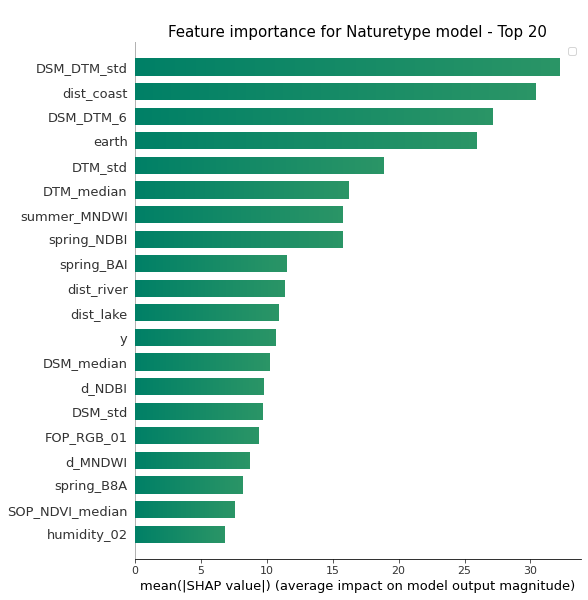

In [20]:
# summarize the effects of all the features in a multi-class barplot
import shap 
import matplotlib.pyplot as plt

# load JS visualization code to notebook
shap.initjs() 

original_shape = nt_shap_values.shape
shap_values_reshaped = nt_shap_values.reshape(original_shape[1], original_shape[0], original_shape[-1])
shap_values_reshaped = list(shap_values_reshaped[:,:,:-1])

shap.summary_plot(shap_values_reshaped, features=train_X[0:103], plot_type = None, alpha = 0.5, show = False, color = plt.get_cmap("summer"))

plt.title('\nFeature importance for Naturetype model - Top 20', fontsize = 15)
plt.legend("")

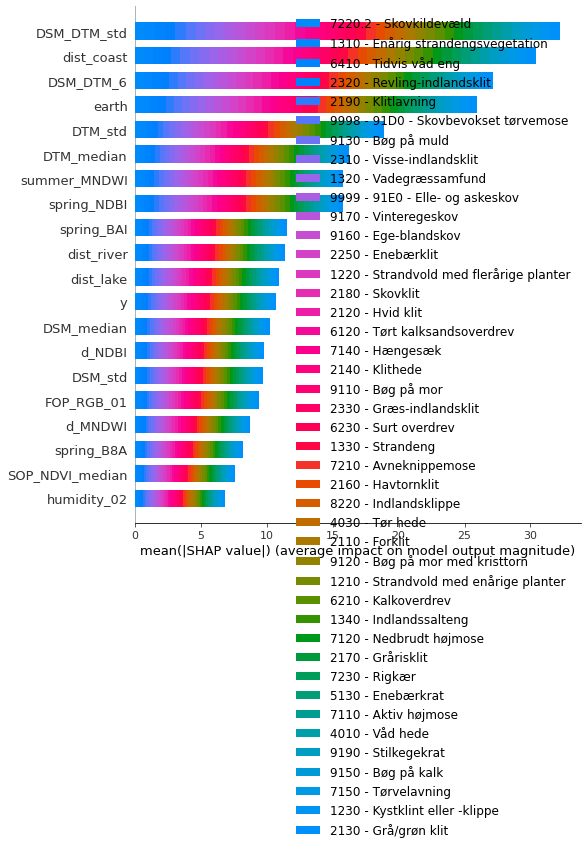

Wall time: 5.62 s


In [21]:
%%time
#explainer_ = shap.TreeExplainer(model_cb)
#shap_values_ = explainer_.shap_values(catboost_pool_shap)
#shap.summary_plot(shap_values_, train_X, class_names = model_cb.classes_)
shap.summary_plot(shap_values_reshaped[0:10000], train_X[0:10000], class_names = model_cb.classes_)
#shap.summary_plot(nt_shap_values, class_names = model_cb.classes_)
# Mangler Hab.Names. -> Ok - se 01_feature_imp

In [ ]:
#shap.summary_plot(shap_values, X_train)

# Mikkels kode
shap_values_ = explainer_.shap_values(catboost_pool_shap)

shap.summary_plot(shap_values_[0], train_X[0].values, feature_names = feature_cb_cols)

# Explainable AI på Longitude & Latitude - punkt.

In [ ]:
# Eksempel på VM-box

In [22]:
# Predict on holdout testdata
preds_proba = model_cb.predict(test_X, prediction_type="Probability")
preds_class = model_cb.predict(test_X, prediction_type="Class")
preds_raw_vals= model_cb.predict(test_X, prediction_type='RawFormulaVal')

# Eller preds_proba = cb_model.predict_proba(data)
print("Class = ", preds_class[0:10])
print("Probability = ", preds_proba[10])
print("Raw = ", preds_raw_vals[10])


Class =  [['9110 - Bøg på mor']
 ['7140 - Hængesæk']
 ['6210 - Kalkoverdrev']
 ['9998 - 91D0 - Skovbevokset tørvemose']
 ['9998 - 91D0 - Skovbevokset tørvemose']
 ['7230 - Rigkær']
 ['6410 - Tidvis våd eng']
 ['9999 - 91E0 - Elle- og askeskov']
 ['7230 - Rigkær']
 ['7140 - Hængesæk']]
Probability =  [4.81662999e-07 8.98509980e-07 4.23914217e-07 9.17201689e-08
 1.01200205e-07 1.40363336e-07 1.00742728e-08 4.02758082e-07
 2.96884464e-07 1.46942013e-04 9.05534555e-04 1.43464454e-05
 1.04375736e-04 5.26893231e-05 1.31015728e-04 9.97712287e-01
 7.61291204e-05 9.30004821e-05 9.48495404e-07 4.09587107e-05
 3.89305955e-04 1.26299565e-04 9.04612982e-07 3.86184724e-06
 2.13619028e-05 1.41503884e-06 2.41229673e-07 1.20705035e-04
 1.97233125e-05 7.59346476e-07 6.36039921e-07 2.22095016e-05
 2.33347406e-06 7.08553151e-07 2.81265993e-06 6.57062182e-07
 7.80989512e-07 6.39778692e-08 1.46752200e-07 5.54995339e-08
 1.16810428e-06 5.96020187e-07 2.17889225e-06]
Raw =  [-1.50932718 -0.88583407 -1.6370407

In [23]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true = test_y, y_pred = preds_class)


array([[ 11,  18,   0, ...,   0,   0,   0],
       [  6, 507,   1, ...,   0,   0,   1],
       [  0,   5, 258, ...,   1,   0,   0],
       ...,
       [  0,   0,   4, ..., 483,  21,  13],
       [  0,   0,   0, ...,  14, 466,  36],
       [  0,   0,   0, ...,  16,  48, 426]], dtype=int64)

In [24]:
# Confusion matrix from catboost
from catboost.utils import get_confusion_matrix
catboost_pool = Pool(data=test_X, 
                     label=test_y,
                     cat_features = ['earth'],)
cm = get_confusion_matrix(model_cb, catboost_pool)
print(cm)

[[ 11.  18.   0. ...   0.   0.   0.]
 [  6. 507.   1. ...   0.   0.   1.]
 [  0.   5. 258. ...   1.   0.   0.]
 ...
 [  0.   0.   4. ... 483.  21.  13.]
 [  0.   0.   0. ...  14. 466.  36.]
 [  0.   0.   0. ...  16.  48. 426.]]


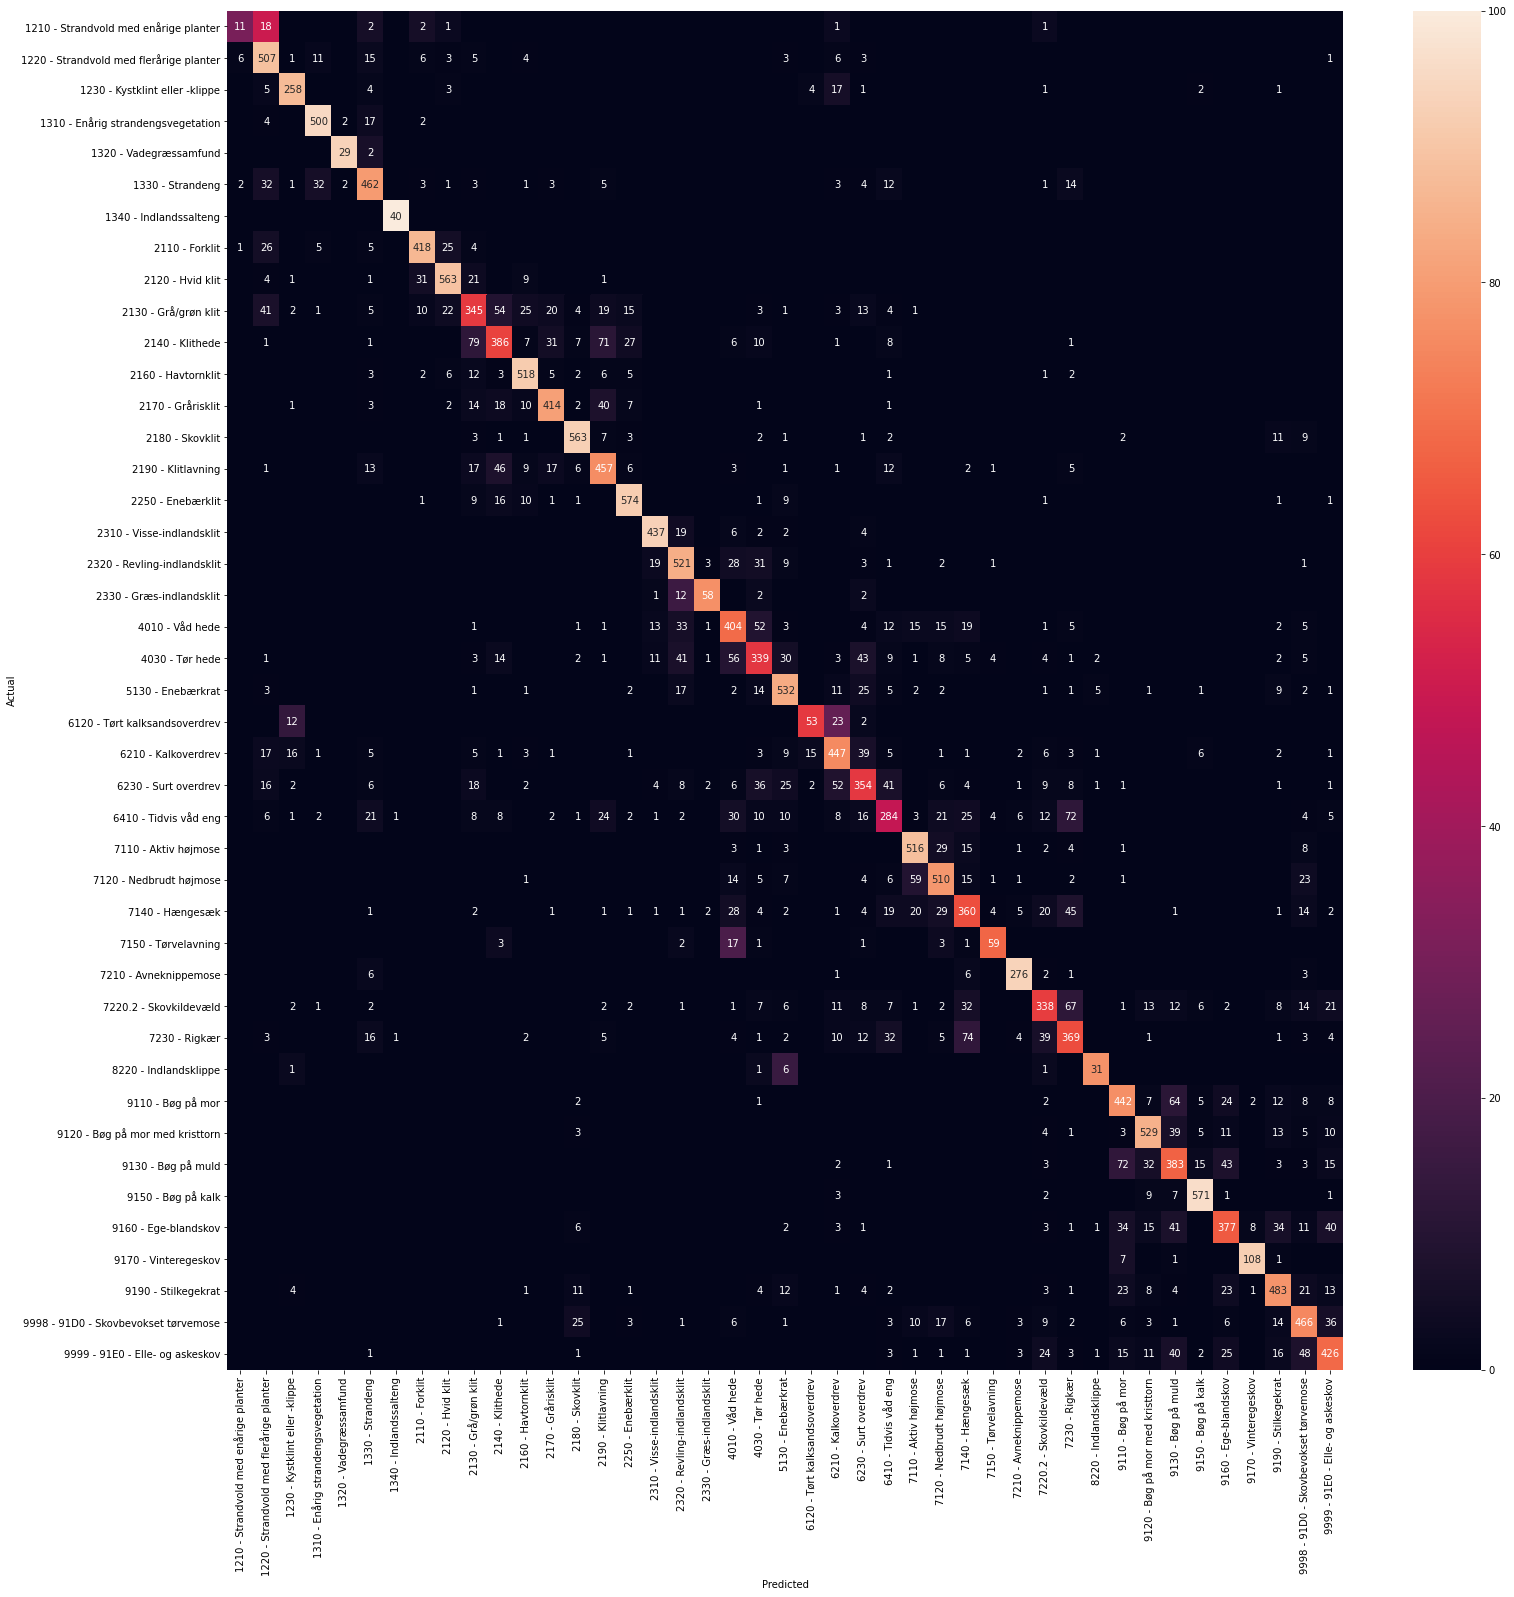

In [25]:
# Confusion matrix custom function
import numpy as np
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                #annot[i, j] = '%.1f%%' % (p) # Vis kun procent
                #annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s) # Vis både procent og label antal
                annot[i, j] = '%d' % (c) # Vis kun label
            elif c == 0:
                annot[i, j] = ''
            else:
                #annot[i, j] = '%.1f%%' % (p) # , c) # Vis kun procent
                #annot[i, j] = '%.1f%%\n%d' % (p, c) # Vis både procent og label antal
                annot[i, j] = '%d' % (c) # Vis kun label antal. d=antal digits. f=float. \n = new line
    #cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.savefig("Confusion_Matrix_2020_ny", bbox_inches='tight') 
    plt.show()

cm_analysis(test_y, preds_class, model_cb.classes_, ymap=None, figsize=(25,25))

In [26]:
# RoC Curve WiP pt. ikke tilgængelig for multiclass
from catboost.utils import get_roc_curve

#catboost_pool = Pool(test_X, test_y)

(fpr, tpr, thresholds) = get_roc_curve(model_cb, catboost_pool, plot=True)
print(fpr[0:10])
print(tpr[0:10])
print(thresholds[0:10])

#get_roc_curve(tuned_model, catboost_pool, plot=True)

CatBoostError: c:/program files (x86)/go agent/pipelines/buildmaster/catboost.git/catboost/private/libs/target/data_providers.cpp:379: Non-Multiclassification and Non-Multiregression compatible metric (Logloss) specified for a multidimensional model

In [ ]:
# RoC Multiclass
from sklearn.metrics import roc_curve, auc
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict(X_test, prediction_type='Class')
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(model_cb, test_X, test_y, n_classes=40, figsize=(16, 10))



# Bayesian Optimization med Scikit-Learn Optimize (skopt)

In [52]:
# Define clf classifier
clf = CatBoostClassifier(thread_count = 2,
                         #loss_function='Logloss',
                         task_type = "GPU", #devices='0:1', #task_type="CPU", device måske ikke nødvendig, ved kun 1 GPU device
                         od_type = 'Iter',
                         cat_features=['earth'],
                         loss_function = 'MultiClass',
                         #loss_function='Logloss',
                         metric_period = 30, # Vis kun hver 30 evaluering
                         verbose= True)

# Prepare Search Space for hyperparameter tuning

In [53]:
# Defining Catboost search space - bruges sammen med 
# Fix log-uniform
search_spaces = {'iterations': (10, 100),
                 #'iterations': (10, 1000),
                 'depth': (1, 8),
                 #'learning_rate': (0.01, 1.0, 'log-uniform'),
                 #'learning_rate': (0.01, 1.0),
                 'learning_rate': (0.01, 0.1),
                 #'random_strength': (1e-9, 10, 'log-uniform'),
                 'random_strength': (1e-9, 10),
                 'bagging_temperature': (0.0, 1.0),
                 #'border_count': (1, 255),
                 #'l2_leaf_reg': (2, 50), # Lazzo
                 'border_count': (1, 5),
                 'l2_leaf_reg': (2, 5), # Lazzo
                 #'scale_pos_weight':(0.01, 1.0, 'uniform')}
                # 'scale_pos_weight':(0.01, 1.0) # Not for multiclass
                }

# Functions for Bayes Search

In [54]:
# Reporting util for different optimizers
# WiP: Handle Categorical Features


#CHECK om dette virker: https://stackoverflow.com/questions/55675253/skopts-bayessearchcv-with-catboost
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optimizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    
    import pandas as pd
    import pprint
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

# RoC-Curver or Area Under Curve:
roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [55]:
# Setting up BayesSearchCV (skopt)
opt = BayesSearchCV(estimator=clf, 
                    search_spaces=search_spaces,
                    #scoring = roc_auc, # custom function
                    scoring = 'accuracy',
                    #cv=skf,
                    cv = 3,# evt. cv = skf
                    n_iter=10,
                    n_jobs=1,  # use just 1 job with CatBoost in order to avoid segmentation fault
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=42)

In [56]:
# from sklearn.preprocessing import label_binarize
# label_binarize([1, 6], classes=[1, 2, 4, 6])
# 
# train_y_bin = preprocessing.label_binarize(y, classes=range(1,42))
# print(train_y_bin)

In [57]:
# Midlertidig 
train_X_noearth = train_X[train_X.columns[~train_X.columns.isin(['earth'])]]
train_X_noearth.dtypes
#train_X.dtypes

humidity_01    float64
humidity_02    float64
humidity_03    float64
humidity_04    float64
pressure_01    float64
                ...   
SOP_RGB_05     float32
SOP_RGB_06     float32
SOP_RGB_07     float32
SOP_RGB_08     float32
SOP_RGB_09     float32
Length: 191, dtype: object

In [59]:
%%time

# Execute bayesian 
# Mangel: categorical features.

best_params = report_perf(optimizer = opt, 
                          X = train_X, #[train_X.columns[~train_X.columns.isin(['earth'])]], # Features skal binarizes eller noget andet
                          y = train_y, 
                          title = 'CatBoost',
                          callbacks=[VerboseCallback(100), DeadlineStopper(60*10)])

# CPU tid: 188 sec
# GPU 38 sec.

Iteration No: 1 started. Searching for the next optimal point.
0:	learn: 3.5188369	total: 522ms	remaining: 19.3s
30:	learn: 1.6668867	total: 21.8s	remaining: 4.92s
37:	learn: 1.5334124	total: 27.2s	remaining: 0us
0:	learn: 3.5168841	total: 490ms	remaining: 18.1s
30:	learn: 1.6616999	total: 22.1s	remaining: 4.99s
37:	learn: 1.5306284	total: 27.7s	remaining: 0us
0:	learn: 3.5236246	total: 566ms	remaining: 21s
30:	learn: 1.6674497	total: 23.2s	remaining: 5.24s
37:	learn: 1.5352093	total: 28.8s	remaining: 0us
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 87.5969
Function value obtained: -0.6131
Current minimum: -0.6131
Iteration No: 2 started. Searching for the next optimal point.
0:	learn: 3.7298498	total: 222ms	remaining: 21.1s
30:	learn: 3.0105092	total: 6.78s	remaining: 14.2s
60:	learn: 2.6726625	total: 13.1s	remaining: 7.49s
90:	learn: 2.4445062	total: 19.3s	remaining: 1.06s
95:	learn: 2.4145051	total: 20.4s	remaining: 0us
0:	learn: 3.7294335	total: 22

In [60]:
# Convert ordered dictionary to dictionary
import json
best_params_bayesian = json.loads(json.dumps(best_params))
print(best_params_bayesian)

{'bagging_temperature': 0.7995534416071731, 'border_count': 3, 'depth': 5, 'iterations': 74, 'l2_leaf_reg': 5, 'learning_rate': 0.07453280360438533, 'random_strength': 4.241780725182642}


In [61]:
%%time
# Træning af model med parametre fundet i Bayesian Optimization processen.
tuned_model = CatBoostClassifier(**best_params_bayesian, # **best_params, 
                                 eval_metric   = 'Accuracy',
                                 loss_function = 'MultiClass',
                                 task_type     = "GPU", 
                                 devices       = '0:1', 
                                 random_seed   = 1337, 
                                 od_type       = 'Iter',
                                 od_wait       = 2000,
                                 metric_period = 10, # Vis kun hver x evaluering
                                 one_hot_max_size = 10)

tuned_model.fit(X = train_X, 
                y = train_y, 
                eval_set=(test_X, test_y), # Tilføj test set 
                cat_features = ['earth'],
                plot = True,
                verbose = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1812166	test: 0.1828971	best: 0.1828971 (0)	total: 308ms	remaining: 22.5s
10:	learn: 0.4416742	test: 0.4430064	best: 0.4430064 (10)	total: 3.68s	remaining: 21.1s
20:	learn: 0.5178262	test: 0.5181676	best: 0.5181676 (20)	total: 7.03s	remaining: 17.7s
30:	learn: 0.5645894	test: 0.5622680	best: 0.5622680 (30)	total: 10.4s	remaining: 14.4s
40:	learn: 0.5891798	test: 0.5856124	best: 0.5856124 (40)	total: 13.7s	remaining: 11s
50:	learn: 0.6083002	test: 0.6024614	best: 0.6024614 (50)	total: 17s	remaining: 7.66s
60:	learn: 0.6246490	test: 0.6180895	best: 0.6180895 (60)	total: 20.3s	remaining: 4.32s
70:	learn: 0.6379087	test: 0.6320570	best: 0.6320570 (70)	total: 23.6s	remaining: 995ms
73:	learn: 0.6406803	test: 0.6343036	best: 0.6343036 (73)	total: 24.6s	remaining: 0us
bestTest = 0.6343035749
bestIteration = 73
Wall time: 26 s


In [62]:
tuned_model.best_score_



{'learn': {'Accuracy': 0.6406803252667822, 'MultiClass': 1.2600611859295254},
 'validation': {'Accuracy': 0.634303574916976,
  'MultiClass': 1.2735300244798788}}

In [261]:
# Create the learning curve visualizer
import numpy as np

from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve

cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)
estimator = CatBoostClassifier(iterations=42, learning_rate=0.3, max_depth=10)

visualizer = LearningCurve(model=estimator, cv=cv, scoring='accuracy', train_sizes=sizes, n_jobs=1)

visualizer.fit(train_X, train_y)        # Fit the data to the visualizer
visualizer.poof()           # Finalize and render the figure

YellowbrickTypeError: Cannot detect the model name for non estimator: '<class 'catboost.core.CatBoostClassifier'>'

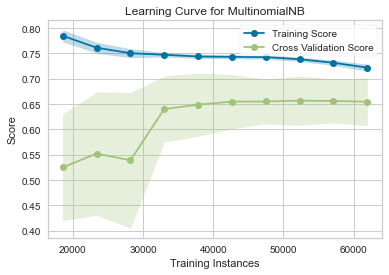

<AxesSubplot:title={'center':'Learning Curve for MultinomialNB'}, xlabel='Training Instances', ylabel='Score'>

In [30]:
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from yellowbrick.datasets import load_game
from yellowbrick.model_selection import LearningCurve

# Load a classification dataset
X, y = load_game()
#X = train_X
#y = train_y

# Encode the categorical data
X = OneHotEncoder().fit_transform(X)
y = LabelEncoder().fit_transform(y)

# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)

# Instantiate the classification model and visualizer
model = MultinomialNB()
#model = CatBoostClassifier()

visualizer = LearningCurve(
    model, cv=cv, scoring='accuracy', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [39]:
# make the prediction using the resulting model
preds_class = tuned_model.predict(test_X, prediction_type='Class')
preds_raw_vals = tuned_model.predict(test_X, prediction_type='RawFormulaVal')
preds_proba = tuned_model.predict(test_X, prediction_type='Probability')

# Eller preds_proba = cb_model.predict_proba(data)
print("class = ", preds_class[0:10])
print("proba = ", preds_proba[0:10])
print("proba = ", preds_raw_vals[0:10])

class =  [['9110 - Bøg på mor']
 ['7110 - Aktiv højmose']
 ['6210 - Kalkoverdrev']
 ['9998 - 91D0 - Skovbevokset tørvemose']
 ['9998 - 91D0 - Skovbevokset tørvemose']
 ['7230 - Rigkær']
 ['7140 - Hængesæk']
 ['9999 - 91E0 - Elle- og askeskov']
 ['7230 - Rigkær']
 ['4010 - Våd hede']]
proba =  [[3.79198845e-04 5.84580729e-04 2.19687999e-03 4.06409625e-04
  3.67573232e-04 4.40634115e-04 4.78852343e-04 3.92269535e-04
  4.35959784e-04 1.20247965e-03 1.22052837e-03 2.88682125e-03
  9.90597947e-04 2.50199830e-03 1.31815538e-03 1.48410347e-03
  6.09864498e-04 7.74552443e-04 4.11510050e-04 3.02856486e-03
  5.11992682e-03 2.61161141e-02 1.23987173e-03 3.61133600e-03
  1.08501990e-02 4.67137077e-03 9.87364475e-04 1.31334694e-03
  1.86791564e-03 4.70385578e-04 8.06974284e-04 1.51591693e-02
  4.72144384e-03 1.07010788e-03 4.11633761e-01 6.15376265e-02
  1.04952539e-01 4.03894203e-02 4.95201753e-02 1.23566218e-02
  1.37798677e-01 1.34875195e-02 6.82065986e-02]
 [4.27295928e-04 7.23794569e-04 4.6543

In [40]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true = test_y, y_pred = preds_class)


array([[  1,  15,   1, ...,   0,   0,   0],
       [  1, 421,   4, ...,   0,   0,   0],
       [  0,   5, 224, ...,   1,   1,   0],
       ...,
       [  0,   1,   5, ..., 359,  32,  17],
       [  0,   0,   0, ...,  33, 384,  34],
       [  0,   0,   0, ...,  35,  84, 249]], dtype=int64)

In [ ]:
# Catboost bayesian optimization performance


In [41]:
# RoC Curve
from catboost.utils import get_roc_curve

catboost_pool = Pool(test_X, test_y)

(fpr, tpr, thresholds) = get_roc_curve(tuned_model, catboost_pool, plot=True)
print(fpr[0:10])
print(tpr[0:10])
print(thresholds[0:10])

#get_roc_curve(tuned_model, catboost_pool, plot=True)

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=42]="MSG": Cannot convert 'b'MSG'' to float

In [267]:
#catboost_auc = eval_metric(toy_example['class'], toy_example['prediction'], 'AUC')[0]
#from catboost import eval_metrics
metrics = ['AUC']
catboost_pool = Pool(test_X, test_y)
catboost_auc = tuned_model.eval_metrics(catboost_pool,
             metrics,
             ntree_start=0,
             ntree_end=0,
             eval_period=1,
             thread_count=-1)

catboost_auc[10]

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=42]="MSG": Cannot convert 'b'MSG'' to float

In [ ]:
# Feature Importance
catboost_pool = Pool(test_X, test_y)
model = CatBoostClassifier(iterations=50, random_seed=42, logging_level='Silent').fit(catboost_pool)
feature_importances = model.get_feature_importance(catboost_pool)
feature_names = dataset.columns # Skal muligvis fixes, så dette trækkes fra train

for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

In [29]:
# Save Model

In [107]:
# Save model as catboost model format
tuned_model.save_model(fname="tuned_model",
                       format="cbm",
                       export_parameters=None,
                       pool=None
                      )



In [118]:
from catboost import CatBoostClassifier, Pool

from_file = CatBoostClassifier()

from_file = from_file.load_model("tuned_model", format="cbm")
from_file
print(from_file.feature_names_)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59']


In [35]:
# Save model as json
tuned_model.save_model(
    "model.json",
    format="json",
    # pool=pool  # this parameter is required only for models with categorical features.
)

In [36]:
# Load json
import json
model = json.load(open("model.json", "r"))
model.keys()

dict_keys(['features_info', 'model_info', 'oblivious_trees', 'scale_and_bias'])

In [37]:
print(model['model_info']['catboost_version_info'])

Git info:
    Commit: e94bcd3987d868ce0832af0a6aa61dc1b123ed45
    Branch: heads/master
    Author: somov <somov@yandex-team.ru>
    Summary: Fix clang-cl build: contrib/libs/lzmasdk
    git-svn info:
    Last Changed Rev: 7251233

Other info:
    Build by: PLATFORM-W10$
    Top src dir: C:\Program Files (x86)\Go Agent\pipelines\BuildMaster\catboost.git
    Top build dir: C:\Users\zomb-ml-platform-msk\.ya\build
    Hostname: platform-w10
    Host information: 
        Microsoft Windows [Version 10.0.17134.1667]

    


In [38]:
model['features_info'].keys()

dict_keys(['float_features'])

In [39]:
model['features_info']['float_features'][0]

{'borders': [0.0052999998442828655,
  0.009050000458955765,
  0.012749999761581421,
  0.04084999859333038,
  0.042900003492832184,
  0.10854999721050262],
 'feature_index': 0,
 'flat_feature_index': 0,
 'has_nans': False,
 'nan_value_treatment': 'AsIs'}

In [40]:

def dump_json(item):
    print(json.dumps(item, indent=2))

dump_json(model['oblivious_trees'][0])  # first_tree

{
  "leaf_values": [
    0.05745703763877551,
    0.19299631041764287,
    -0.030025542612934893,
    0.019527848974632226,
    0.019527848974632226,
    -0.002808464337917916,
    0,
    0,
    -0.006103316708903552,
    0.06211021830953289,
    -0.10187758078403128,
    -0.055473038596464436,
    -0.09273474460102127,
    -0.045450835803532166,
    0,
    0,
    0,
    0.09729657445188579,
    0,
    0,
    -0.07726183711735377,
    -0.0672446855714295,
    0,
    -0.055473038596464436,
    -0.07726183711735377,
    -0.04683029633336233,
    0,
    -0.07726183711735377,
    -0.10187758078403128,
    -0.098715328593874,
    -0.12733725677963087,
    -0.055473038596464436
  ],
  "leaf_weights": [
    4.49561619758606,
    28.343217432498932,
    1,
    2.74780809879303,
    2.74780809879303,
    17.73904049396515,
    0,
    0,
    3.74780809879303,
    7.243424296379089,
    6.873904049396515,
    2,
    8.74780809879303,
    16.117328345775604,
    0,
    0,
    0,
    9.865136444568